In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np

c:\Users\e1000\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Lectura del dataset.

In [2]:
df = pd.read_csv('data.csv')

In [3]:
def quit_space(text):
    text = text.lower()
    text = text.replace('\n', ' ')
    text = text.replace('\t', ' ')
    return text

Tokenizacion y division de dataset.

In [4]:
from sklearn.model_selection import train_test_split

df['Code1'] = df['Code1'].apply(quit_space)
df['Code2'] = df['Code2'].apply(quit_space)

x_features = df[['Code1', 'Code2']]
y_labels = df['Plagio']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_features, y_labels, test_size=0.2, random_state=42)

# Tokenización y padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['Code1'] + X_train['Code2'])

X_train_code1_sequences = tokenizer.texts_to_sequences(X_train['Code1'])
X_train_code2_sequences = tokenizer.texts_to_sequences(X_train['Code2'])
X_test_code1_sequences = tokenizer.texts_to_sequences(X_test['Code1'])
X_test_code2_sequences = tokenizer.texts_to_sequences(X_test['Code2'])

max_length = max(max(len(seq) for seq in X_train_code1_sequences), max(len(seq) for seq in X_train_code2_sequences),
                 max(len(seq) for seq in X_train_code1_sequences), max(len(seq) for seq in X_train_code2_sequences))

# max_length = 5416

X_train_code1_padded = pad_sequences(X_train_code1_sequences, maxlen=max_length)
X_train_code2_padded = pad_sequences(X_train_code2_sequences, maxlen=max_length)
X_test_code1_padded = pad_sequences(X_test_code1_sequences, maxlen=max_length)
X_test_code2_padded = pad_sequences(X_test_code2_sequences, maxlen=max_length)

# Sumar las secuencias de Code1 y Code2
X_train_combined = X_train_code1_padded + X_train_code2_padded
X_test_combined = X_test_code1_padded + X_test_code2_padded

print(max_length)


5417


In [5]:
# Verificar dimensiones
print(f'Dimensión de X_train_combined: {X_train_combined.shape}')
print(f'Dimensión de X_test_combined: {X_test_combined.shape}')

Dimensión de X_train_combined: (728, 5417)
Dimensión de X_test_combined: (183, 5417)


Definicion del classificador RF

In [6]:
input_dim = max(tokenizer.word_index.values()) + 1
classifier = RandomForestClassifier()
classifier.fit(X_train_code1_padded + X_train_code2_padded, y_train)

RandomForestClassifier()

In [7]:
# Verificar si el clasificador ha sido entrenado
print(f"Número de características de entrada esperadas por el clasificador: {classifier.n_features_in_}")

Número de características de entrada esperadas por el clasificador: 5417


Generamos nuestra matriz de confusion.

Matriz de Confusión:
[[175   0]
 [  7   1]]


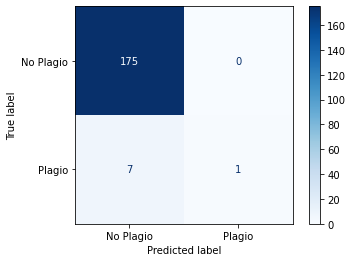

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predicciones en los datos de prueba
y_pred = classifier.predict(X_test_combined)
y_pred_classes = np.round(y_pred)

# Crear la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_classes)

print("Matriz de Confusión:")
print(conf_matrix)

disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['No Plagio', 'Plagio'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Probamos con test.

In [ ]:
# Convertir las probabilidades en clases predichas
y_pred_test = (y_pred > 0.8).astype("int32") 

# Calcular F1 y Recall y Accuracy
f1 = f1_score(y_test, y_pred_test, average="macro")
recall = recall_score(y_test, y_pred_test, average="macro")
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average="macro")

# Para obtener un reporte completo
report = classification_report(y_test, y_pred_test)
print("Classification Report:\n", report)

In [15]:
print("F1 Score Test: {:.2f}%".format(f1 * 100))
print("Recall Test: {:.2f}%".format(recall * 100))
print("Accuracy Test: {:.2f}%".format(accuracy * 100))
print("Precision Test: {:.2f}%".format(precision * 100))


F1 Score Test: 60.13%
Recall Test: 56.25%
Accuracy Test: 96.17%
Precision Test: 98.08%


Queries al modelo.

In [16]:
def es_plagio(code1, code2):
    # Preprocesamiento de los códigos
    code1_processed = quit_space(code1)
    code2_processed = quit_space(code2)
    
    # Tokenización y padding
    code1_sequence = tokenizer.texts_to_sequences([code1_processed])
    code2_sequence = tokenizer.texts_to_sequences([code2_processed])
    
    code1_padded = pad_sequences(code1_sequence, maxlen=max_length, padding='post', truncating='post')
    code2_padded = pad_sequences(code2_sequence, maxlen=max_length, padding='post', truncating='post')
    
    # Sumar las secuencias de code1 y code2
    combined_code = code1_padded + code2_padded
    
    # Predicción del modelo
    plagiarism_prob = classifier.predict_proba(combined_code)[:, 1]  # Obtener la probabilidad de la clase positiva
    
    # Imprimir la probabilidad de plagio
    print(plagiarism_prob)
    
    # Si la probabilidad de plagio es alta (por ejemplo, mayor que 0.5), se considera plagio
    if plagiarism_prob > 0.75:
        return "Plagio detectado."
    else:
        return "No hay plagio."

In [17]:
# Ejemplo de uso
code1 = """public class AreaTriangulo {

    public static void main(String[] args) {
        // Declaración de variables en orden inverso
        double altura = 3.0;
        double base = 5.0;
        double area;

        // Cálculo del área (mismo que el código 1)
        area = (base * altura) / 2;

        // Impresión del resultado (mismo que el código 1)
        System.out.println("El área del triángulo es: " + area);
    }
}"""


code2 = """public class AreaTriangulo {

    public static void main(String[] args) {
        // Declaración de variables
        double base = 5.0;
        double altura = 3.0;
        double area;

        // Cálculo del área
        area = (base * altura) / 2;

        // Impresión del resultado
        System.out.println("El área del triángulo es: " + area);
    }
}"""

resultado = es_plagio(code1, code2)
print(resultado)


[0.76]
Plagio detectado.
